In [41]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import csv
from sklearn.preprocessing import Normalizer

def dict_to_matrix(dictionary):
    '''
    Does convert a pandas dataframe into a matrix where 
    Parameters
    ----------
    dictionary : dict,
        keys = row name
        values = col name
    data : int, either 0 or 1 
    '''
    unique_values = set(val for sublist in dictionary.values() for val in sublist)
    data_dict = {key: {val: 1 if val in values else 0 for val in unique_values} for key, values in dictionary.items()}
    df = pd.DataFrame(data_dict).T
    return(df)


def overlapping_elements(list1, list2, threshold=70):
    '''
    Find overlapp between to lists with a threshold (=70)
    
    Parameters
    ----------
    list1: list
    list2: list
    threshold: int, fixed to 70
    '''
    overlap = []
    for elem1 in list1:
        for elem2 in list2:
            ratio = fuzz.ratio(elem1, elem2)
            if ratio >= threshold:
                overlap.append(elem1)
    return overlap


def dataframe_to_dict(df):
    '''
    Convert DataFrame to dictionary

    Parameters
    ----------
    df: dataframe
    '''
    result_dict = {}
    for index, row in df.iterrows():
        if row[0] in result_dict:
            result_dict[row[0]].append(row[1])
        else:
            result_dict[row[0]] = [row[1]]
    return result_dict     


def find_matching_entries(dictionary,df):
    '''
    Find match between dictionary entries and the rows of a dataframe
    
    Parameters:
    -----------
    dictionary: dict
    df: dataframe
    '''
    threshold = 80
    found_match = []
    found_match_per_entry = {}
    for key, value in dictionary.items():
        all_matches = set()
        for index, row in df.iterrows():
            for keyword in value:
                if fuzz.ratio(keyword, str(index).lower()) >= threshold:
                    all_matches.add(index)
                    found_match.append(row)
        found_match_per_entry[key] = all_matches
    found_match = pd.DataFrame(found_match)
    found_match = found_match.drop_duplicates()
    #remove empty entries
    '''found_match = found_match.loc[:, (found_match != 0).any(axis=0)]
    found_match_per_entry = {key: value for key, value in found_match_per_entry.items() if value}
    '''
    return(found_match, found_match_per_entry)


def create_matrix_from_dict(dictionary,df,ms_cas):
    '''
    Create a new matrix by finding matches and filtering right columns
    
    Parameters:
    -----------
    dictionary: dict
    df: dataframe
    '''
    matrix = pd.DataFrame(columns=list(df), index=ms_cas)
    final_dict = {}
    for key, value in dictionary.items():
        current_val = []
        for v in value:
            for index, row in df.iterrows():
                if index == v:
                    current_val.append(','.join(row.loc[row.eq(1)].index.tolist()))
                    # todo: maybe exception -> do change if two ones in a row
                    matrix.loc[key][row.loc[row.eq(1)].index.tolist()] = 1
        final_dict[key] = set(current_val)
    matrix = matrix.fillna(0)
    matrix = matrix.loc[:, (matrix != 0).any(axis=0)]
    return(final_dict, matrix)


def read_massspec_data(file_path, replicate, sample_key, n):
    ''''
    Get a dataframe with cas numbers and largest intensities (n times)
    
    Parameters:
    ----------
    file_path: string, path to file
    replicate: int, 1 2 or 3
    sample_key: str
    n: int, nlargest
    '''
    data = pd.read_csv(file_path, delimiter=',')
    data = data[data["sample_key"]== sample_key]
    data = data[data["replicate"] == replicate]
    # filter columns that are 0 
    data = data.loc[:, (data != 0).any(axis=0)]
    data = data.drop(columns=['sample_key', 'replicate'])
    largest_entries = data.iloc[0].nlargest(n)
    data_top_entries = pd.DataFrame({'Intensities':largest_entries})
    return (data_top_entries)


def flavornet_dataframe():
    '''
    read flavornet data and save it in mol_to_OD
    '''
    mol_to_OD = {}
    descriptors = []
    CAS_numbers= []
    with open('./data/CAS_mol_OD.csv', 'r',encoding='utf-8') as tabfile:
        reader = csv.reader(tabfile, delimiter=',')
        for row in reader: 
            molecule = row[0]
            CAS = row[1]
            OD = row[3]
            CAS_numbers.append(CAS)
            descriptors.append(OD)
            if CAS in mol_to_OD:
                mol_to_OD[CAS].add(OD)
            else:
                mol_to_OD[CAS]  = set([OD])
    CAS_numbers = list(set(CAS_numbers))
    descriptors = list(set(descriptors))
    D = pd.DataFrame(index=CAS_numbers, columns=descriptors)
    for col in D.columns:
        for index, row in D.iterrows():
            # Check if value in  current row matches any entry in the dictionary
            if index in mol_to_OD.keys() and col in mol_to_OD[index]:
                # Set to 1
                D.at[index, col] = 1
    D = D.fillna(0)
    return (D,mol_to_OD)


def get_ms_cas(sample_key, n):
    replicate = 1
    file_path = 'data/cas_intensities.csv'
    top_cas = read_massspec_data(file_path, replicate, sample_key,n)
    ms_cas = list(top_cas.index)
    I_vector = top_cas
    return(ms_cas, I_vector)

def match_mol_with_flavors(ms_cas,mol_to_OD):
    flavors = []
    mol_flavors = {}
    for mol in ms_cas:
        if mol in mol_to_OD.keys():
            flavors += mol_to_OD[mol]
            mol_flavors[mol] = mol_to_OD[mol]
        else:
            mol_flavors[mol] = {}
    found_flavors = set(flavors)
    return(found_flavors,mol_flavors)

def OD_X_OQ():
    Research_data = pd.read_csv('./data/swri_flavorwheel.csv', sep=';')
    Research_OQ_OD =  Research_data.drop(columns=Research_data.columns[0])
    Research_OSA_OQ = Research_data.drop(columns=Research_data.columns[2])
    OD_OQ = dict_to_matrix(dataframe_to_dict(Research_OQ_OD)).T
    OQ_OSA = dict_to_matrix(dataframe_to_dict(Research_OSA_OQ)).T
    # filter out rows with only 0
    OD_OQ = OD_OQ.loc[(OD_OQ.iloc[:,1:] != 0).any(axis=1)]
    OQ_OSA = OQ_OSA.loc[(OQ_OSA.iloc[:,1:] != 0).any(axis=1)]
    return(OD_OQ,OQ_OSA)


def I_Vector(I_vector, ms_cas,OSAs):
    normalizer = Normalizer()
    I_vector_normalized = normalizer.fit_transform(I_vector.T).T
    final_OSA = OSAs*I_vector_normalized
    final_OSA_plotting = final_OSA.sum()*10
    return (final_OSA_plotting)


In [42]:
D, mol_to_OD = flavornet_dataframe()
OD_OQ, OQ_OSA = OD_X_OQ()

In [43]:
def main(sample_key,n):
    ms_cas,I_vector = get_ms_cas(sample_key,n)
    
    found_flavors,mol_flavors = match_mol_with_flavors(ms_cas,mol_to_OD)
    print("1) ODs found")
    
    # find matching OQs to found ODs from massspec x flavornet
    matching_OQs, matching_OQs_dict = find_matching_entries(mol_flavors, OD_OQ)
    OQ_dict, OQs = create_matrix_from_dict(matching_OQs_dict, matching_OQs,ms_cas)
    print("2) OQs found")

    # find matching OQs to found ODs from massspec x flavornet
    matching_OSAs, matching_OSAs_dict = find_matching_entries(OQ_dict, OQ_OSA)
    OSA_dict, OSAs = create_matrix_from_dict(matching_OSAs_dict, matching_OSAs,ms_cas)
    print("3) OSAs found")

    final_OSA_plotting = I_Vector(I_vector, ms_cas, OSAs)
    return OSAs, I_vector,final_OSA_plotting

In [17]:
n = 150

In [73]:
OSA_sample_000920, intensities_000920, OSA_plotting_000920 = main("000920",n)
OSA_sample_000586, intensities_000586, OSA_plotting_000586= main("000586",n)
OSA_sample_000636, intensities_000636, OSA_plotting_000636 = main("000636",n)



1) ODs found
2) OQs found
3) OSAs found
1) ODs found
2) OQs found
3) OSAs found
1) ODs found
2) OQs found
3) OSAs found


In [ ]:
OSA_sample_000920, intensities_000920, OSA_plotting_000920 = main("000920",n)
OSA_sample_000586, intensities_000586, OSA_plotting_000586= main("000586",n)
OSA_sample_000636, intensities_000636, OSA_plotting_000636 = main("000636",n)



1) ODs found
2) OQs found
3) OSAs found
1) ODs found
2) OQs found
3) OSAs found
1) ODs found
2) OQs found
3) OSAs found


In [18]:
OSA_sample_000544, intensities_000544, OSA_plotting_000544 = main("000544",n)


1) ODs found
2) OQs found
3) OSAs found


In [290]:
OSA_sample_000879, intensities_000879, OSA_plotting_000879 = main("000879",150)


1) ODs found
2) OQs found
3) OSAs found


In [291]:
OSA_sample_000373, intensities_000373, OSA_plotting_000373 = main("000373",150)


1) ODs found
2) OQs found
3) OSAs found


## Comparison

### check correlation

In [14]:
def get_panelist_profile(sample_key):
    panelist_profile=[]
    for OSA in overlap_OSAs :
        panelist_profile.append(int(panelist_data_df.loc[sample_key][OSA]/10))
    return panelist_profile

In [22]:
def find_overlapping_profiles(final_OSA,comparable_OSAs):
    # show only overlap meaning: floral, fruit, sweet, wood, peat
    new_series = pd.Series() 
    threshold = 80
    for comparable_OSA in comparable_OSAs:
        for index in final_OSA.index:
            if fuzz.ratio(str(index).lower(), comparable_OSA) >= threshold:
                new_series[comparable_OSA] = final_OSA[index]
                break
            else:
                new_series[comparable_OSA] = 0
    return(new_series)


In [2]:
overlap_OSAs = ["floral", "fruit", "sweet", "wood", "peat"]

In [5]:
# look at panelist 1
panelist_data_df = pd.read_table("data/vlb_data_combined.txt", delimiter=',', index_col = 1)
panelist_data_df = panelist_data_df[panelist_data_df["panelist"]==1]
panelist_data_df = panelist_data_df.drop(columns=["panelist", "date"])

over all samples

In [53]:
# ms data
data = pd.read_csv('data/cas_intensities.csv', delimiter=',', index_col = 0)
# only use first repliat
data = data[data["replicate"]==1]
ms_data = data.drop(columns=["replicate"])

In [55]:
# filter for compareable data
valid_indexes = [index for index in panelist_data_df.index if index in ms_data.index]


panelist_data_df and ms_data - comparable dataframes

In [58]:
panelist_data_df = panelist_data_df.loc[valid_indexes]

In [59]:
ms_data = ms_data.loc[valid_indexes]

(array([ 1.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0., 57.,  0.,  0.,
         0.,  0., 75.,  0.,  0.,  0.,  0., 35.,  0.,  0.,  0.,  0., 16.,
         0.,  0.,  0.,  1.]),
 array([10., 12., 14., 16., 18., 20., 22., 24., 26., 28., 30., 32., 34.,
        36., 38., 40., 42., 44., 46., 48., 50., 52., 54., 56., 58., 60.,
        62., 64., 66., 68., 70.]),
 <BarContainer object of 30 artists>)

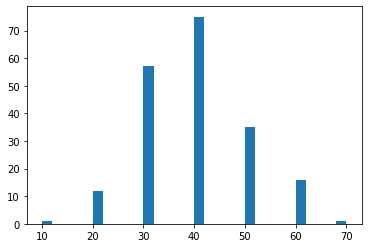

In [71]:
plt.hist(panelist_data_df["sweet"],30)

In [322]:
# create blanck dataframe containing all comparable samples with the predicted OSA using the ms data
data = {
    "samplekey": valid_indexes}
all_samples_OSAs= pd.DataFrame(data,columns=["samplekey",]+overlap_OSAs)
all_samples_OSAs.set_index("samplekey", inplace=True)

all_samples_OSAs


,floral,fruit,sweet,wood,peat
samplekey,,,,,
000656,NaN,NaN,NaN,NaN,NaN
000657,NaN,NaN,NaN,NaN,NaN
000658,NaN,NaN,NaN,NaN,NaN
000838,NaN,NaN,NaN,NaN,NaN
000839,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
000925,NaN,NaN,NaN,NaN,NaN
000926,NaN,NaN,NaN,NaN,NaN
000927,NaN,NaN,NaN,NaN,NaN


In [324]:
'''
create new dataframe containing all comparable samples with the predicted OSA using the ms data
'''
def workflow_all_samples(all_samples,n):
    data = {"samplekey": valid_indexes}
    all_samples_OSAs= pd.DataFrame(data,columns=["samplekey",]+overlap_OSAs)
    all_samples_OSAs.set_index("samplekey", inplace=True)
    for sample_key in all_samples.index:
        OSA_sample, intensities, OSA_plotting = main(sample_key,n)
        OSA_compare = find_overlapping_profiles(OSA_plotting, overlap_OSAs)
        all_samples_OSAs.loc[sample_key] = OSA_compare
        print(sample_key)
    return(all_samples_OSAs)


In [152]:
# compute all predicted flavor profiles for each sample using the ms data
all_samples_ms_pred = workflow_all_samples(ms_data, 150)

1) ODs found
2) OQs found
3) OSAs found
000656


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000657


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000658


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000838


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000839


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000856


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000860
1) ODs found


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



2) OQs found
3) OSAs found
000862
1) ODs found


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



2) OQs found
3) OSAs found
000874


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000875


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000878
1) ODs found


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



2) OQs found
3) OSAs found
000879


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000880
1) ODs found


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



2) OQs found
3) OSAs found
000909


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000914


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000918


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000919


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000923


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000924


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000842


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000853


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000855


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000861


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000911


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000928


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000931


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000426


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000428


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000427


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000430


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000431


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000432


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000434


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000435


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000436


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000438


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000439


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000441


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000444


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000445


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000447


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000450


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000481


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000484


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000489


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000491


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000492


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000493


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000494


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000504


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000505


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000507


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000510


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000511


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000512


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000513


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000515


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000516


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000517


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000518


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000519


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000520


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000524


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000525


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000527


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000528


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000529


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000530


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000535


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000536


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000563


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000564


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000565


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000569


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000575


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000578


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000579


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000580


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000581


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000548


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000586


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000588


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000590


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000591


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000595


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000598


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000605


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000606


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000607


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000611


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000617


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000618


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000619


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000622


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000627


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000628


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000629


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000632


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000633


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000354


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000356


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000357


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000361


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000362


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000365


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000367


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000369


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000371


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000373


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000375


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000376


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000377


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000378


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000379


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000382


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000384


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000386


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000387


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000388


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000389


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000390


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000393


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000394


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000396


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000398


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000401


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000402


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000403


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000404


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000405


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000406


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000407


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000408


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000410


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000411


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000412


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000413


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000414


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000415


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000416


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000418


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000419


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000420


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000421


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000423


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000424


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000425


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000383


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000395


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000400


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000429


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000437


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000453
1) ODs found


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



2) OQs found
3) OSAs found
000552


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000558


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000566


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000568


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000570


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000572


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000573


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000574


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000576


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000577


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000582


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000587


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000593


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000594


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000596


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000600


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000603


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000610


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000613


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000614


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000616


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000623


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000626


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000634


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000635


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000636


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000642


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000643


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000646


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000651


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000653


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000659


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000699


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000910


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000912


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000915


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000917


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000920


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000922


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000925


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000926


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000927


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000929


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



1) ODs found
2) OQs found
3) OSAs found
000930


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [215]:
# round preditctions so that scale is in steps of 10 
rounded_ms_pred = all_samples_ms_pred.applymap(lambda x: round(x, 0))*10

1. simple plot to see difference

(array([ 2.,  1.,  3.,  1.,  3.,  2.,  1.,  5., 12., 10., 12., 16., 27.,
        16., 16., 15., 14.,  8., 12.,  7.,  3.,  1.,  2.,  0.,  1.,  2.,
         2.,  2.,  0.,  1.]),
 array([6.683018898442803, 6.830160635491157, 6.977302372539509,
        7.124444109587863, 7.271585846636216, 7.418727583684569,
        7.565869320732922, 7.713011057781275, 7.860152794829628,
        8.007294531877982, 8.154436268926334, 8.301578005974688,
        8.448719743023041, 8.595861480071394, 8.743003217119746,
        8.8901449541681, 9.037286691216453, 9.184428428264805,
        9.33157016531316, 9.478711902361512, 9.625853639409865,
        9.77299537645822, 9.920137113506572, 10.067278850554924,
        10.214420587603279, 10.361562324651631, 10.508704061699984,
        10.655845798748338, 10.80298753579669, 10.950129272845043,
        11.097271009893397], dtype=object),
 <BarContainer object of 30 artists>)

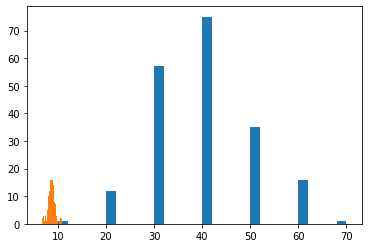

In [179]:
plt.hist(panelist_data_df["sweet"],30)
plt.hist(all_samples_ms_pred["sweet"],30)

(array([ 10.,   0.,   0.,   0.,   0.,   0.,   0.,  66.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,
         16.,   0.,   0.,   0.,   0.,   0.,   0.,   5.]),
 array([ 70.        ,  71.33333333,  72.66666667,  74.        ,
         75.33333333,  76.66666667,  78.        ,  79.33333333,
         80.66666667,  82.        ,  83.33333333,  84.66666667,
         86.        ,  87.33333333,  88.66666667,  90.        ,
         91.33333333,  92.66666667,  94.        ,  95.33333333,
         96.66666667,  98.        ,  99.33333333, 100.66666667,
        102.        , 103.33333333, 104.66666667, 106.        ,
        107.33333333, 108.66666667, 110.        ]),
 <BarContainer object of 30 artists>)

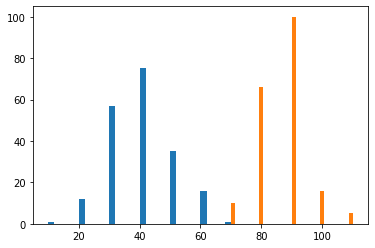

In [218]:
# rounded values
plt.hist(panelist_data_df["sweet"],30)
plt.hist(rounded_ms_pred["sweet"],30)

# TODO: intensities normalize between 0 and 10

2. normalize

In [325]:
def normalize_flavorprofile(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    return scaled_data


look at distribution of sweet over all samples

In [330]:
all_samples_ms_pred["sweet"]

samplekey
000656     8.948716
000657     8.468189
000658     9.040464
000838    11.097271
000839     8.730873
            ...    
000925     9.102066
000926     9.559293
000927     9.060663
000929     9.332631
000930     9.177692
Name: sweet, Length: 197, dtype: object

In [332]:
panelist_data_df["sweet"]

samplekey
000656    30
000657    30
000658    40
000838    50
000839    50
          ..
000925    30
000926    40
000927    50
000929    30
000930    70
Name: sweet, Length: 197, dtype: int64

In [362]:
sweet_pred_norm = normalize_flavorprofile(all_samples_ms_pred["sweet"]*10)
sweet_pred_rounded_norm = normalize_flavorprofile(rounded_ms_pred["sweet"])
sweet_panelist_norm = normalize_flavorprofile(panelist_data_df["sweet"])

In [366]:
rounded_ms_pred["sweet"]

samplekey
000656     90.0
000657     80.0
000658     90.0
000838    110.0
000839     90.0
          ...  
000925     90.0
000926    100.0
000927     90.0
000929     90.0
000930     90.0
Name: sweet, Length: 197, dtype: float64

(array([ 10.,   0.,  66.,   0.,   0., 100.,   0.,  16.,   0.,   5.]),
 array([-2.13935602, -1.63462173, -1.12988743, -0.62515314, -0.12041884,
         0.38431545,  0.88904975,  1.39378404,  1.89851834,  2.40325263,
         2.90798692]),
 <BarContainer object of 10 artists>)

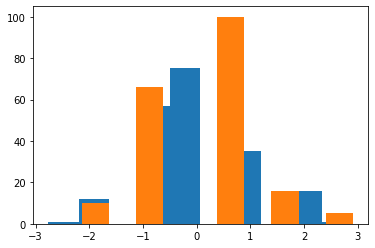

In [364]:
#plt.hist(sweet_pred_norm)
plt.hist(sweet_panelist_norm)
plt.hist(sweet_pred_rounded_norm)

In [365]:
# wont work since we didnt scale the pred intensities right
np.corrcoef(np.array(sweet_pred_rounded_norm), np.array(sweet_panelist_norm))[0,1]

c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning:

divide by zero encountered in divide

c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning:

invalid value encountered in multiply



nan

nan


c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning:

divide by zero encountered in divide

c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning:

invalid value encountered in multiply



nan

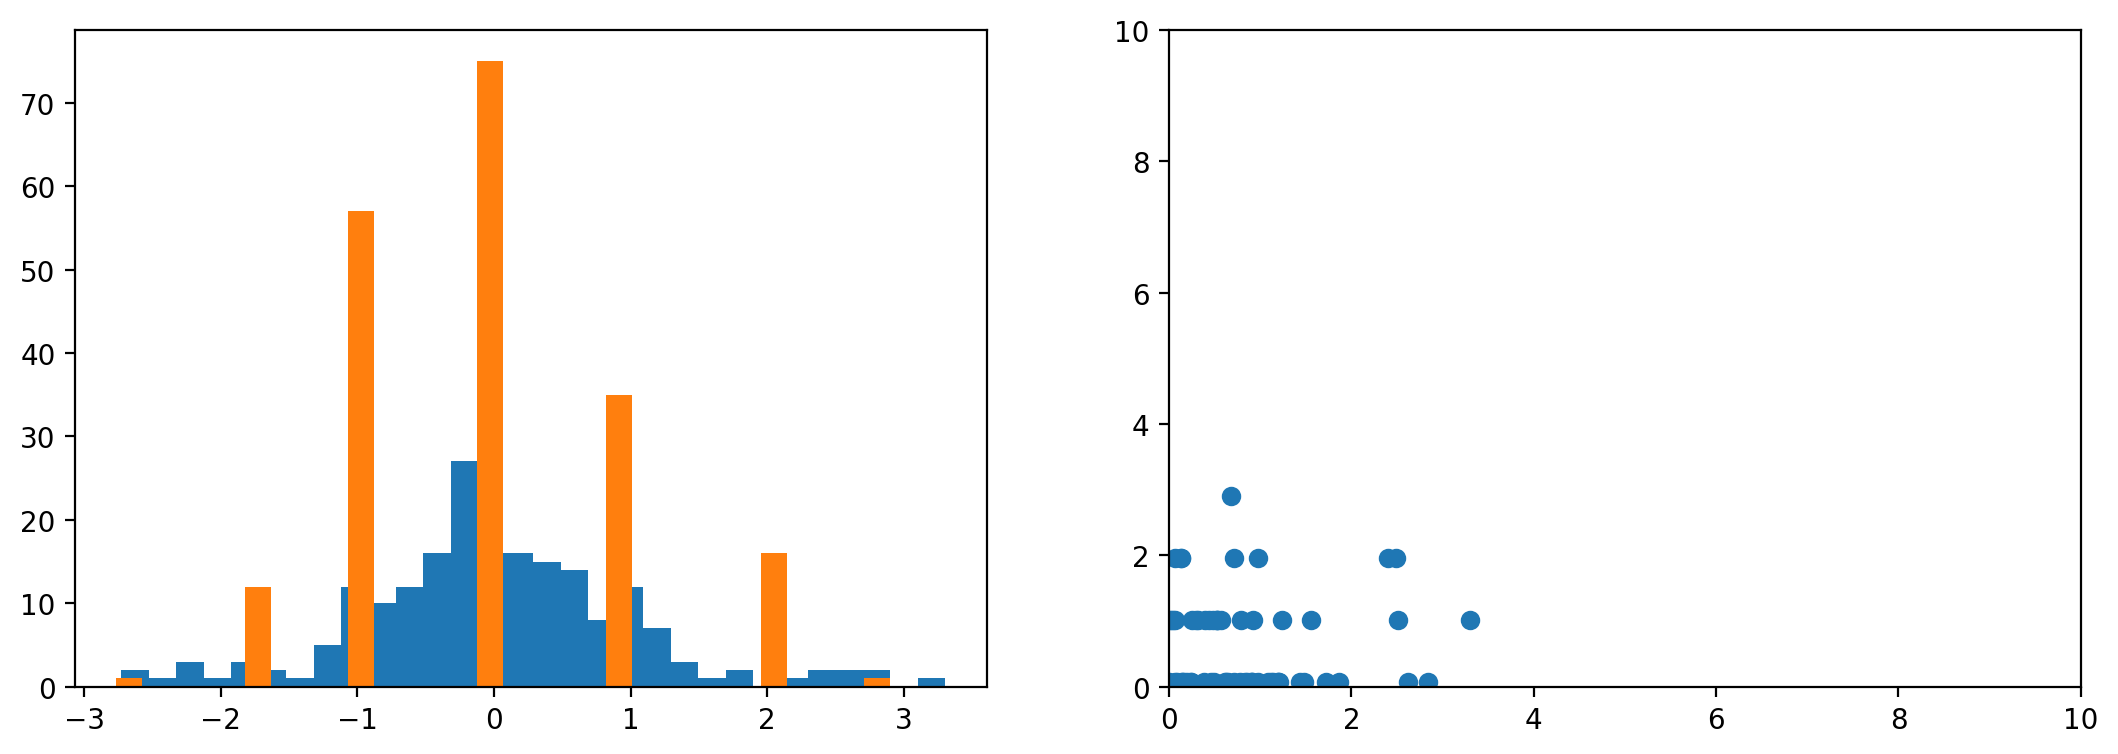

In [367]:
check_correlation(sweet_pred_norm,sweet_panelist_norm)

In [334]:
from sklearn.preprocessing import StandardScaler
'''
input: normalized arrary of one flavor
return: correlation of this flavor between two data sets: ms data and panelist data
'''
def check_correlation(data_ms, data_panelist):
    plt.figure(figsize=(20, 20), dpi=200)

    plt.subplot(4, 3, 1)
    plt.hist(data_ms,30)
    plt.hist(data_panelist,30)

    plt.subplot(4, 3, 2)
    plt.plot(data_ms,data_panelist,"o")
    plt.xlim(0,10)
    plt.ylim(0,10)

    correlation = np.corrcoef(np.array(data_ms), data_panelist)[0,1]
    print(correlation)
    return(correlation)

0.013660934981636357
0.01057687702535939
0.03468812316687167
0.047862502232124834
nan


c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning:

invalid value encountered in divide



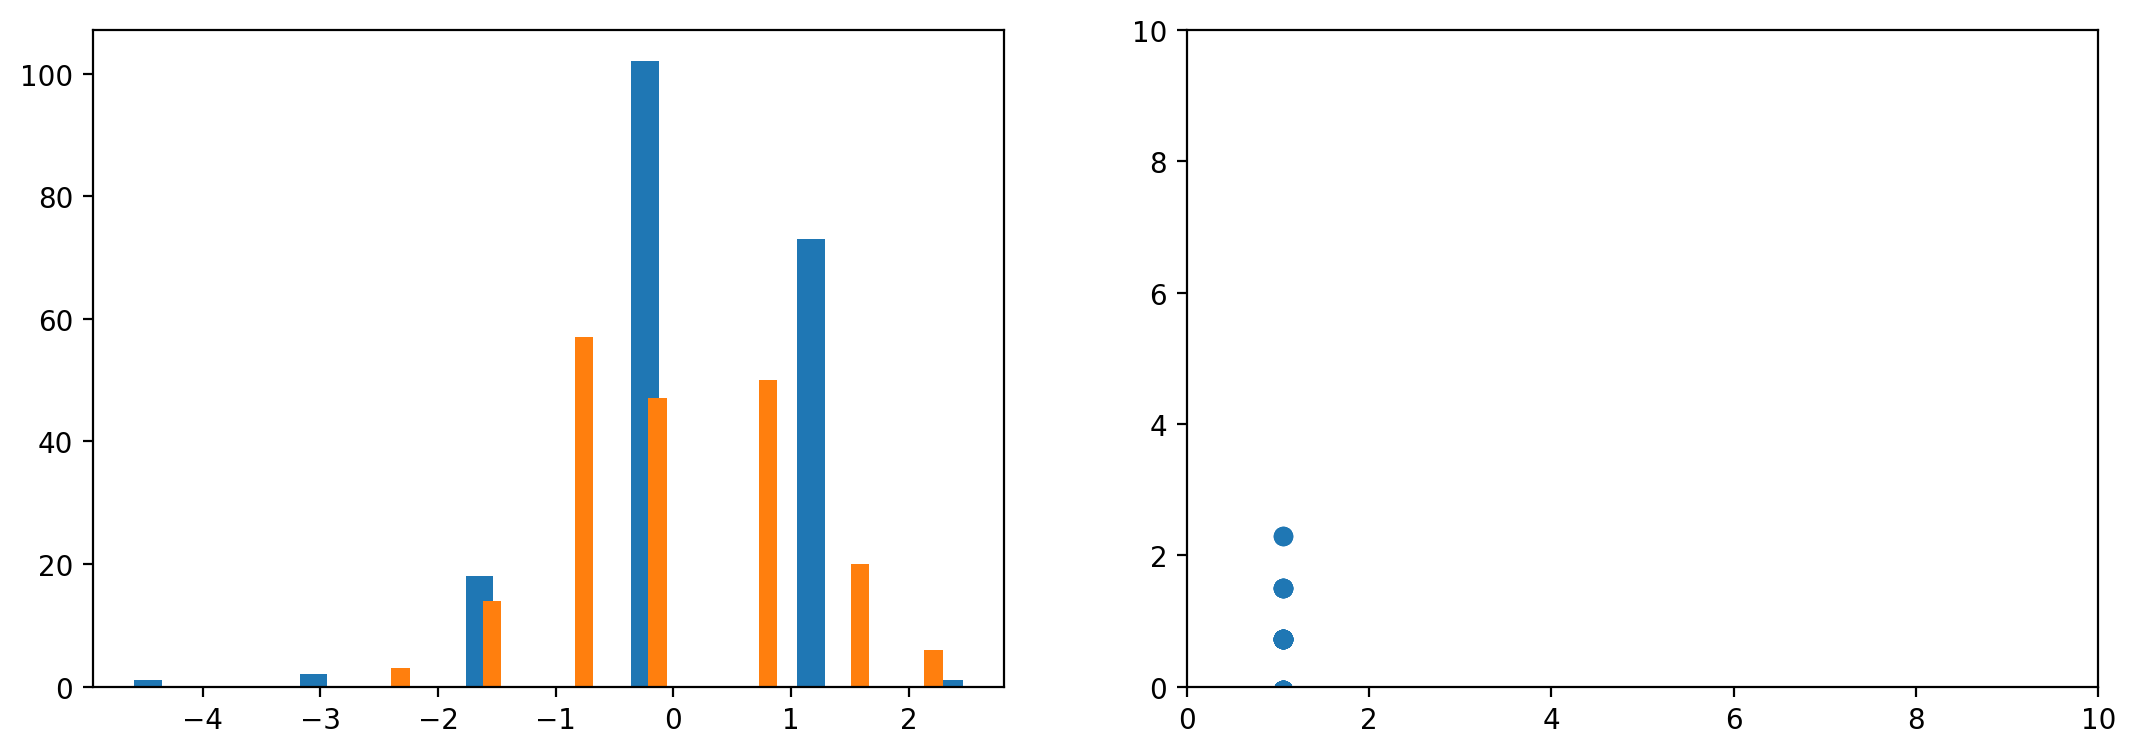

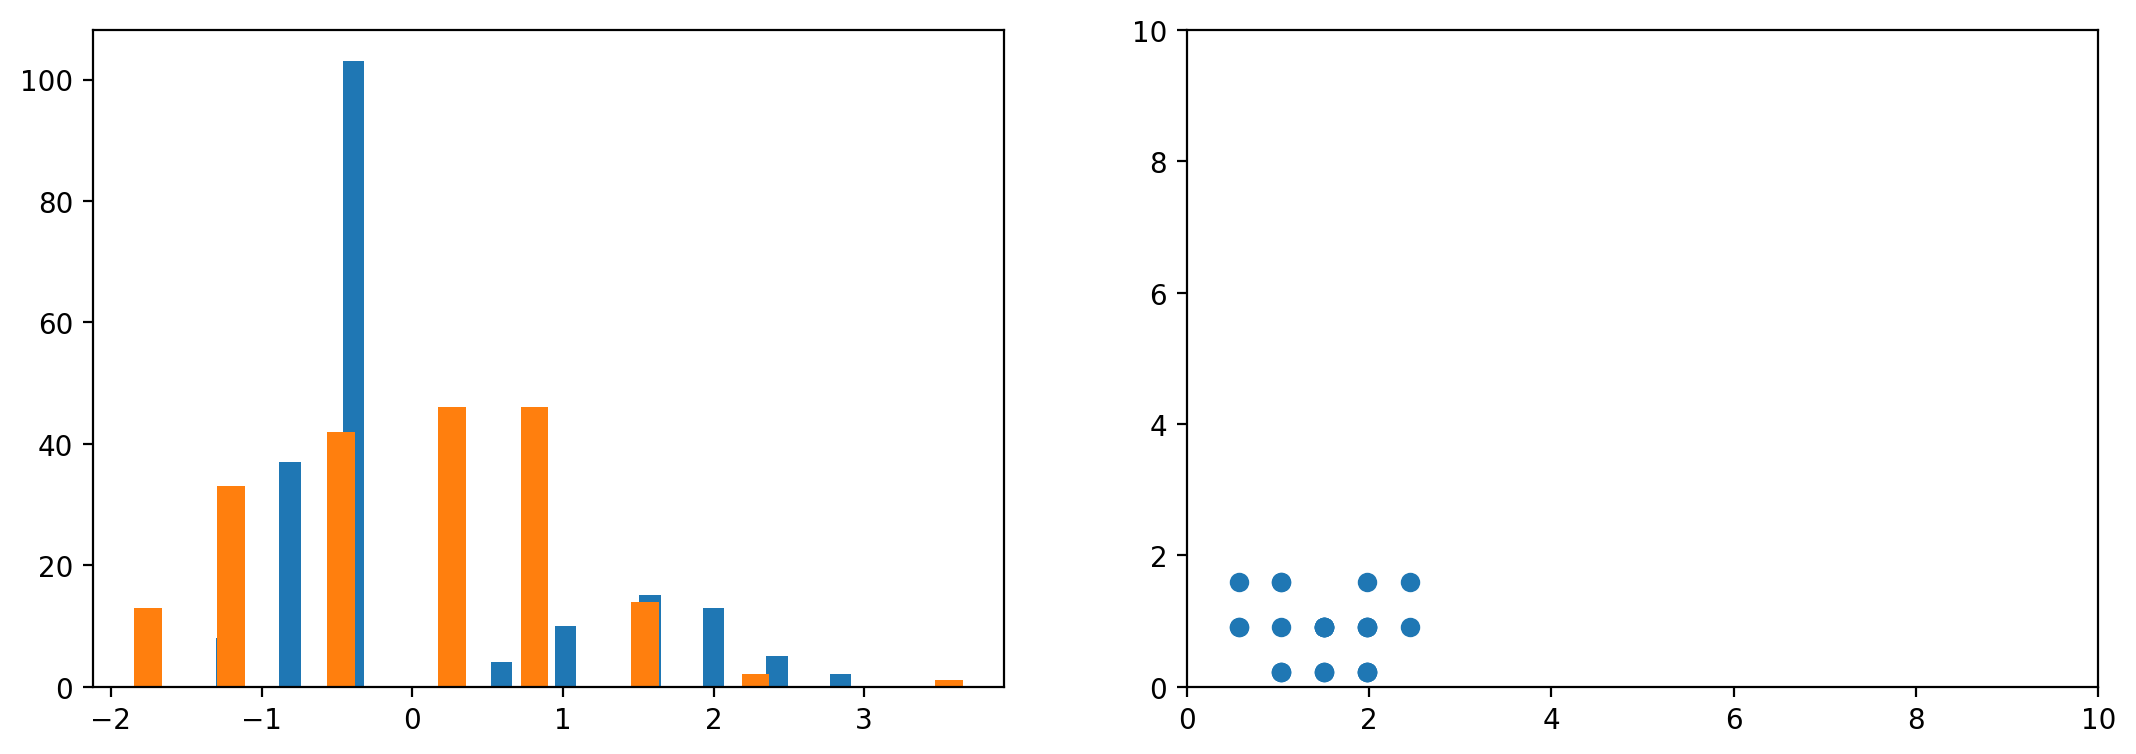

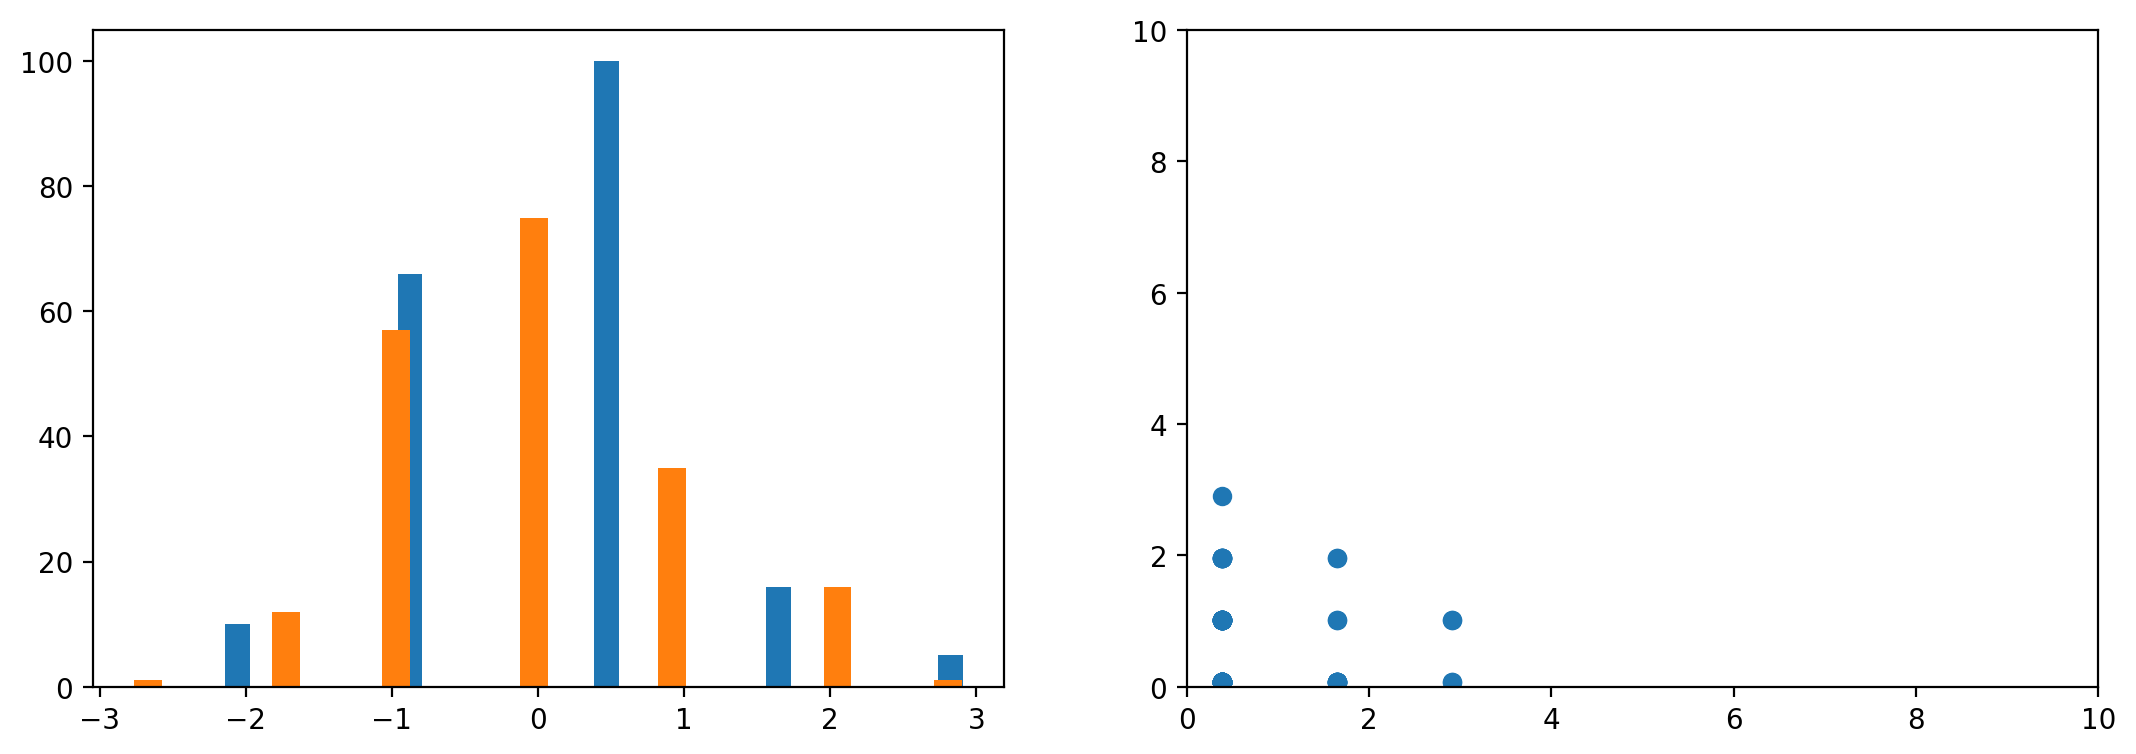

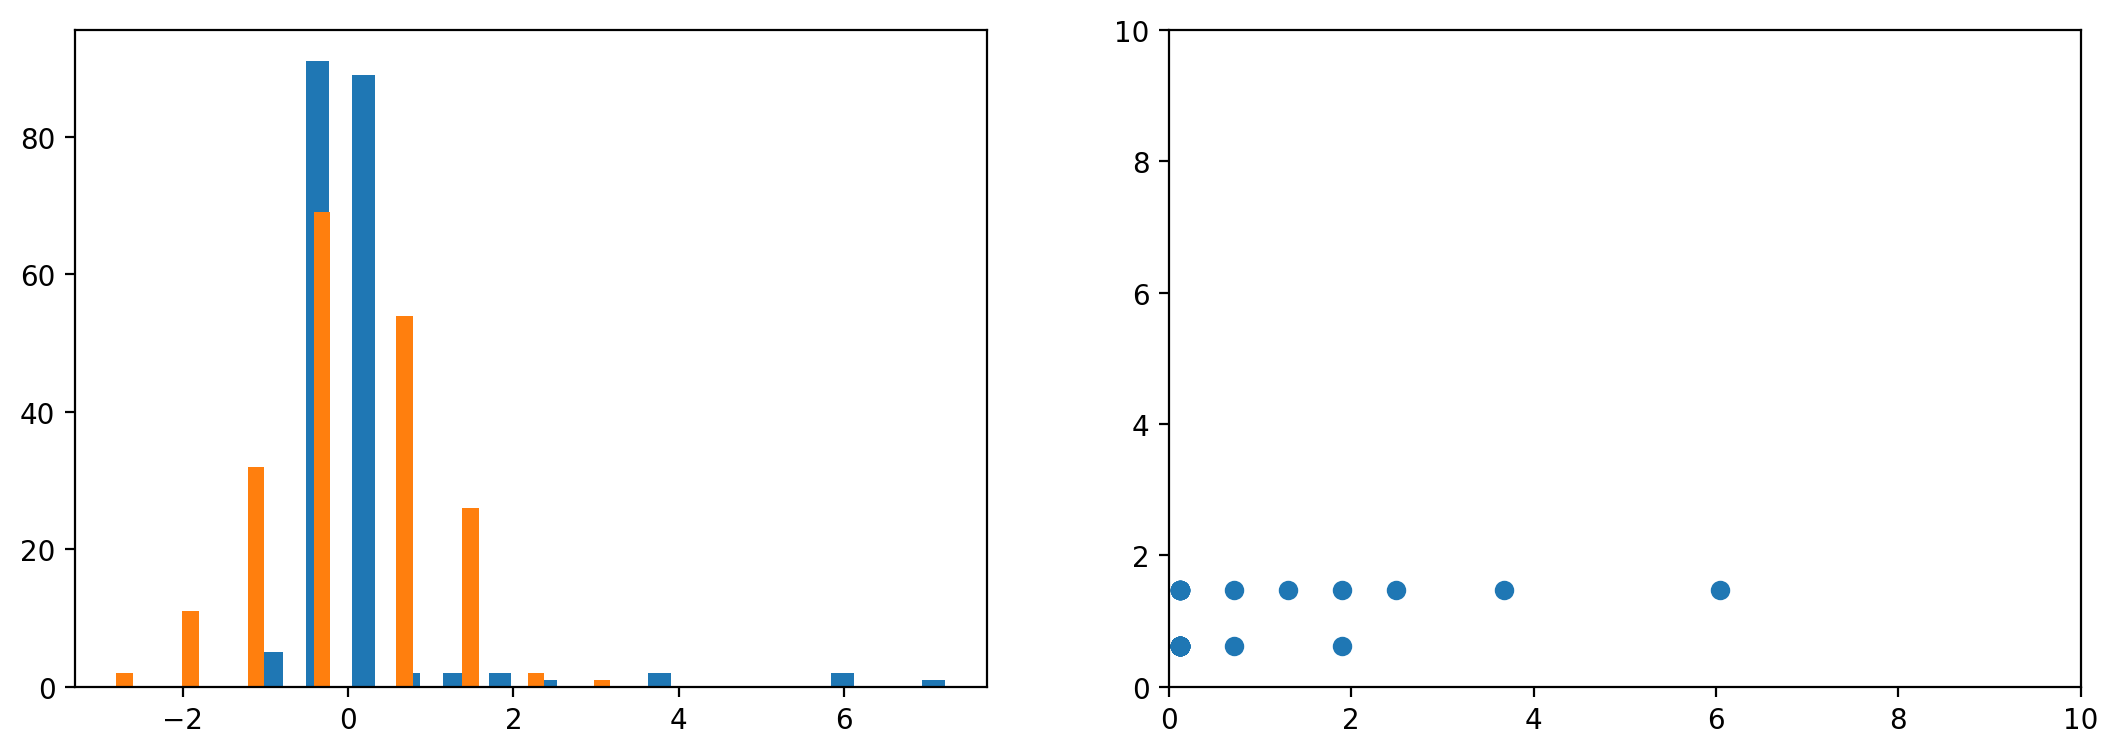

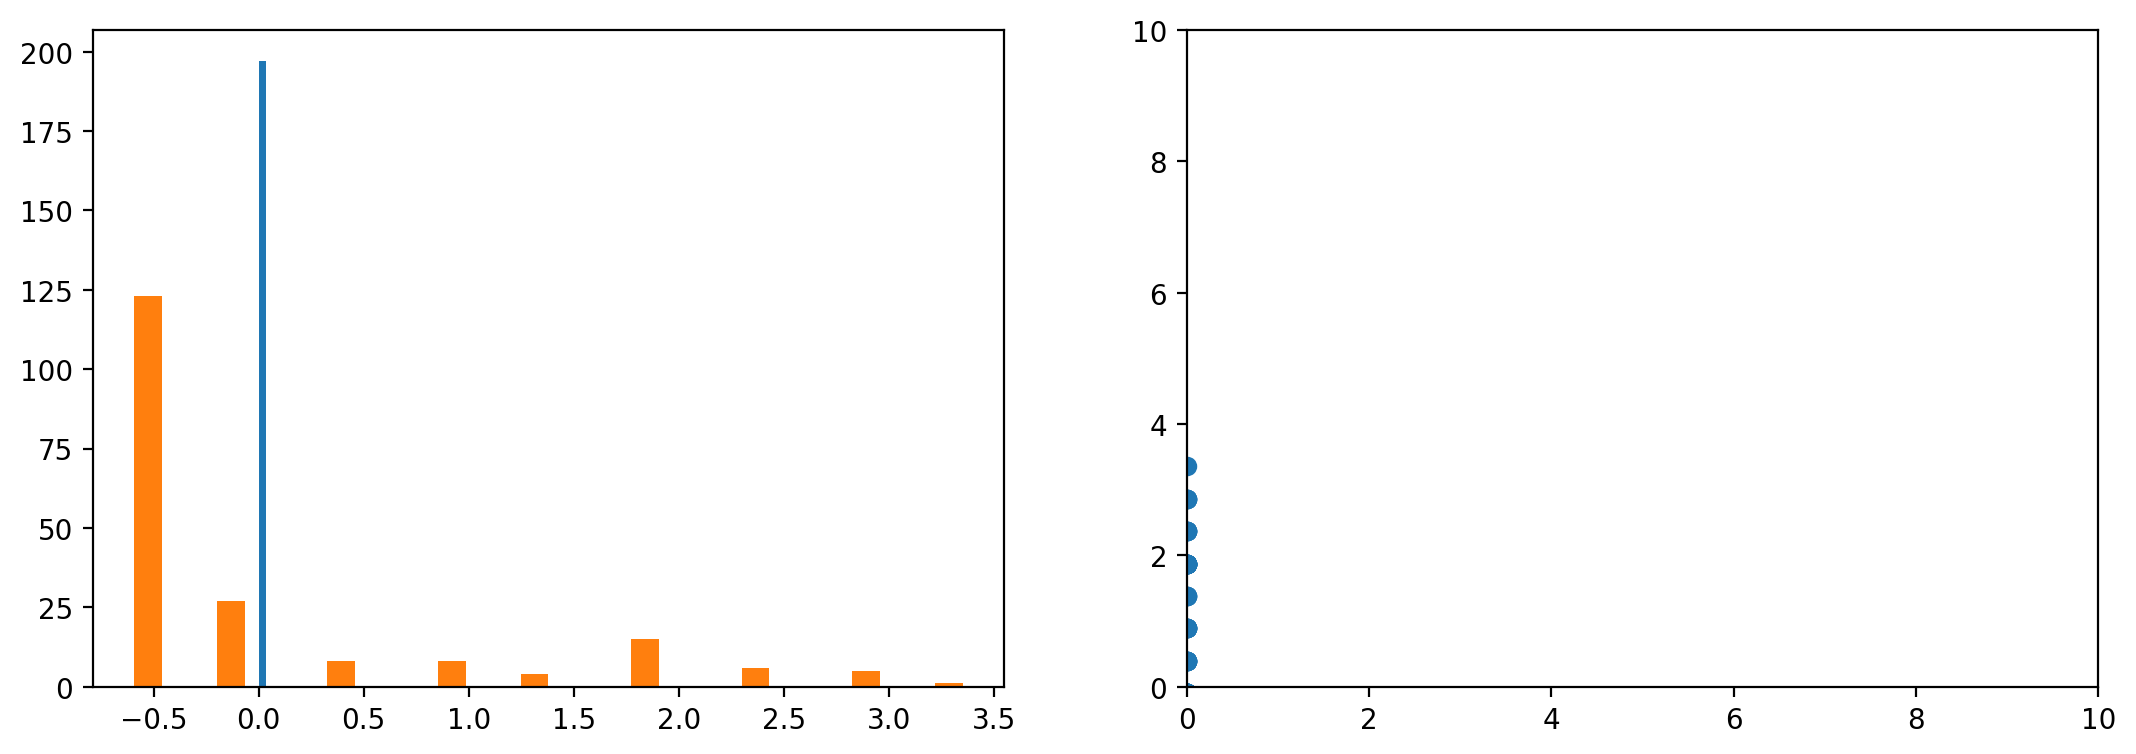

In [294]:
# check for correlation in each comparable flavor
for flavor in rounded_ms_pred.columns:
    check_correlation(rounded_ms_pred[flavor],panelist_data_df[flavor])

0.03468812316687167


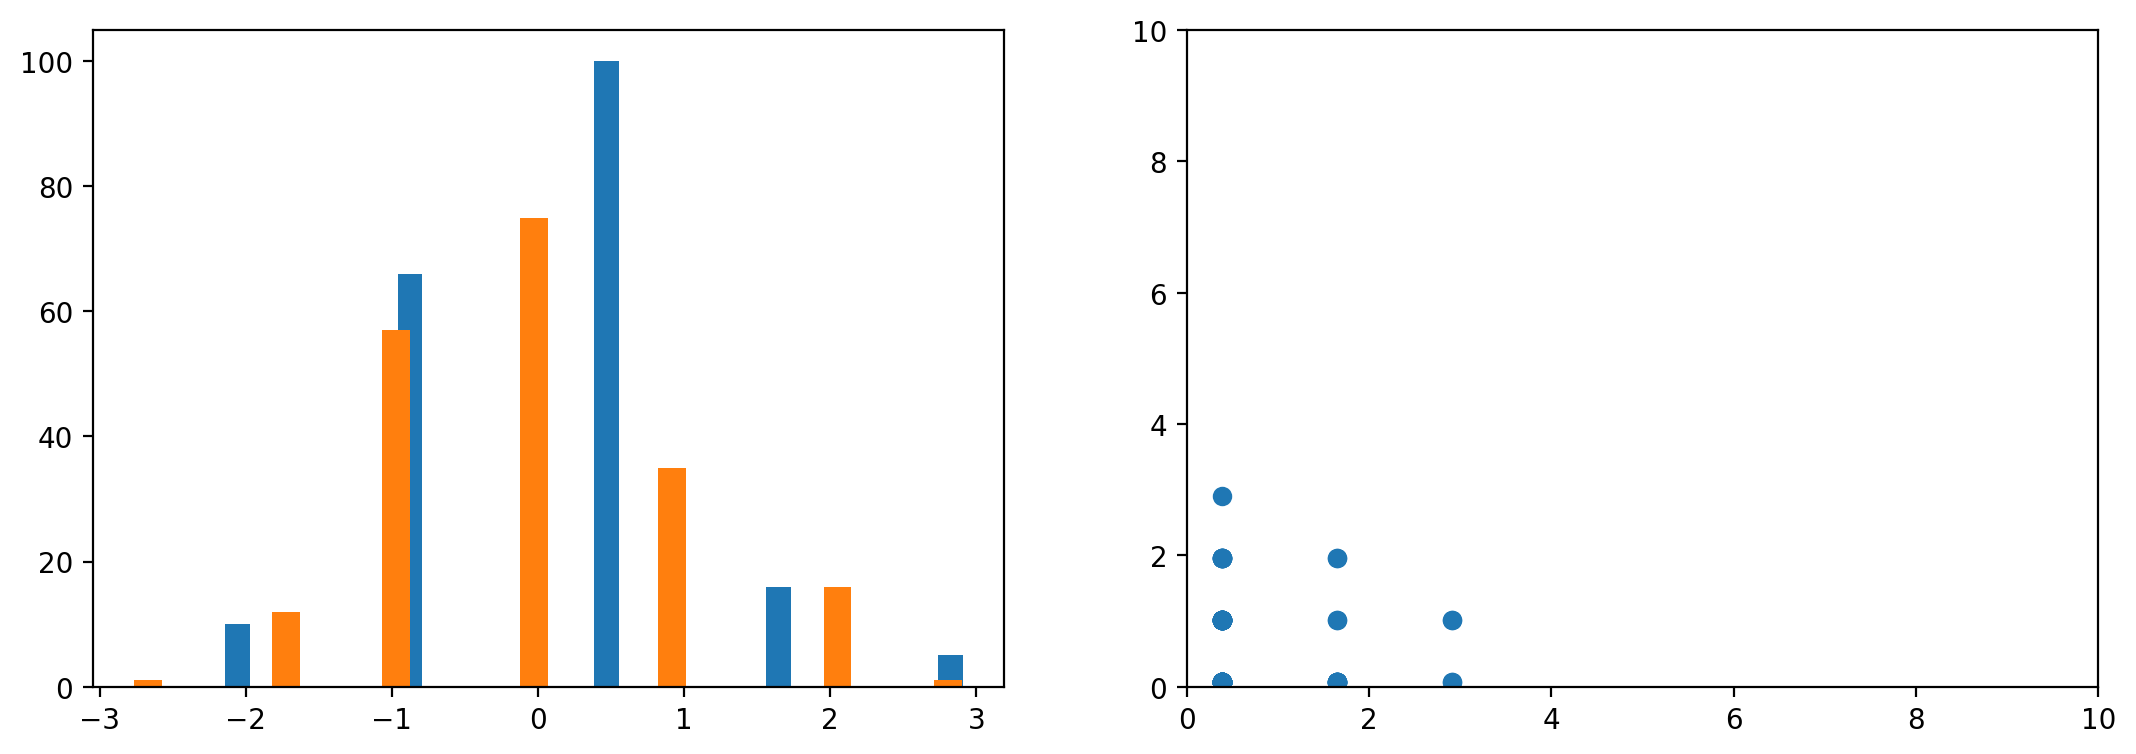

In [286]:
correlation_sweet=check_correlation(rounded_ms_pred["sweet"],panelist_data_df["sweet"])

### visualize

*OSAs from panelist:* floral, fruit, wood, complexity, malt, sweet, peat, dried_fruits

*OSAs from flavorwheel:* floral,fruity, solventy, soapy, sweet, woody, nutty, spicy, oily, sour, sulphury, stale, peaty, feinty, cereal, green/grassy 

*Overlapp:* floral, fruit,sweet, wood, peat

In [28]:
import plotly.graph_objects as go

#only compare only columns from final_OSA
def compare_profiles(final_OSA, panelists):
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=panelists,
        theta=list(final_OSA.index),
        fill='toself',
        name="panelist"
    ))

    fig.add_trace(go.Scatterpolar(
    r=(np.array(final_OSA)),
    theta=list(final_OSA.index),
    fill='toself',
    name= "MS_prediction"))

    fig.update_layout(
    polar=dict(
        radialaxis=dict(
        visible=True,
        range=[0, 10]
        )),
    showlegend=False
    )

    fig.show()

##### *compare only overlap*

meaning only those OSAs: "floral", "fruit", "sweet", "wood", "peat"

AttributeError: 'float' object has no attribute 'dtype'

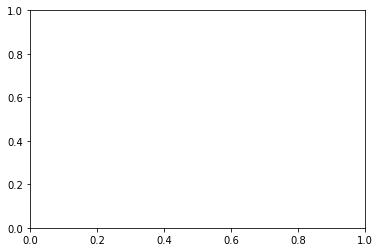

In [368]:
plt.hist(all_samples_OSAs["sweet"])

In [29]:
def compare_visual(sample_key, n):
    OSA_sample, intensities, OSA_plotting = main(sample_key,n)
    OSA_compare = find_overlapping_profiles(OSA_plotting, overlap_OSAs)
    panelist_compare = get_panelist_profile(sample_key)
    compare_profiles(OSA_compare.T, panelist_compare)

In [37]:
n = 400

In [44]:
compare_visual("000920", n)

1) ODs found
2) OQs found
3) OSAs found


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [45]:
compare_visual("000636", n)

1) ODs found
2) OQs found
3) OSAs found


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [46]:
compare_visual("000633", n)

1) ODs found
2) OQs found
3) OSAs found


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



##### *compare OSAs with available panelist data for found MS-OSAs*

meaning MS-OSA flavorprofile + a part of the panelist profile

In [239]:
OSA_plotting_000920.index

Index(['feinty', 'Green/grassy', 'Floral', 'Fruity ', 'Solvently', 'Soapy',
       'Sweet', 'Woody', 'Spicy', 'Sour', 'Stale'],
      dtype='object')

In [258]:
#panelist original: ["floral", "fruit", "sweet", "wood", "peat"]
panelist_scores_000920 = [0,0,4,3,0,0,4,5,0,0,0]
compare_profiles(OSA_plotting_000920, panelist_scores_000920)

In [250]:
OSA_plotting_000636.index

Index(['feinty', 'Green/grassy', 'Floral', 'Fruity ', 'Solvently', 'Soapy',
       'Sweet', 'Woody', 'Spicy', 'Sulphury', 'Stale'],
      dtype='object')

In [255]:
#["floral", "fruit", "sweet", "wood", "peat"]
panelist_scores_000636 = [0,0,4,5,0,0,4,5,0,0,0]

compare_profiles(OSA_plotting_000636, panelist_scores_000636)

In [252]:
OSA_plotting_000633.index

Index(['feinty', 'cereal', 'Green/grassy', 'Floral', 'Fruity ', 'Solvently',
       'Soapy', 'Sweet', 'Woody', 'Spicy', 'Sulphury', 'Stale'],
      dtype='object')

In [254]:
#["floral", "fruit", "sweet", "wood", "peat"]
panelist_scores_000633 = [0,0,0,3,4,0,0,9,3,0,0,0]
compare_profiles(OSA_plotting_000633, panelist_scores_000633)


#### todo: compare panelist data with available MS - OSAs

### compare flavorprofiles with biggest variance

In [49]:
compare_visual("000879",n)

1) ODs found
2) OQs found
3) OSAs found


C:\Users\Franz\AppData\Local\Temp\ipykernel_2860\2645404678.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [275]:
OSA_plotting_000879["Soapy"]=0
OSA_plotting_000373['cereal']= 0

In [ ]:
#panelist 000879
#floral,fruit,wood,complexity,malt,sweet,peat,dried_fruits,aftertaste
#30,60,60,50,30,50,0,40,60
#[0,0,0,3,6,0,5,6,0,0,0,0,0]

In [294]:
panelist_scores_000879 =[0,0,0,3,6,0,5,6,0,0,0,0,0]
compare_profiles(OSA_plotting_000879, panelist_scores_000879)

In [ ]:
#panelist 000373
#floral,fruit,wood,complexity,malt,sweet,peat,dried_fruits,aftertaste
#30,60,70,60,50,40,0,50,70,
#[0,0,3,6,0,0,4,7,0,0,0,0,0]

In [293]:
panelist_scores_000373 =[0,0,3,6,0,0,4,7,0,0,0,0,0]
compare_profiles(OSA_plotting_000373, panelist_scores_000373)
